# 2025-01-15 Finite Differences


## Last time

* General shape of PDE solvers and stakeholders
* Comparing/plotting cost and accuracy


## Today

* Scoping
* Learning strategy
* Evaluating derivatives
* Taylor series and truncation error
* Stability

In [3]:
using Plots
default(linewidth=3)
using LinearAlgebra

# Choices in scoping the class

## Theory

Analysis first, confirm using numerics.
Limited to simpler models.

## Applied
Numerics first, pointers to useful theory.

---

## Build from scratch

Limited to simpler models, but you'll understand everything under the hood.

## Build using libraries

More installation and software layers, but can solve more interesting problems.

# What I need from you: Growth Mindset

<img src="img/Henry2019-Table1.png" width="90%" />

# Consider the boundary value problem: find $u$:

\begin{gather} -\frac{d^2 u}{dx^2} = f(x) \quad x \in \Omega = (-1,1) \\
u(-1) = a \quad \frac{du}{dx}(1) = b .
\end{gather}

We say
* $f(x)$ is the "forcing"
* the left boundary condition is Dirichlet
* the right boundary condition is Neumann

We need to choose
* how to represent $u(x)$, including evaluating it on the boundary,
* how to compute derivatives of $u$,
* in what sense to ask for the differential equation to be satisfied,
* where to evaluate $f(x)$ or integrals thereof,
* how to enforce boundary conditions.

# Finite Difference/collocation approach to solve $u$:

\begin{gather} -\frac{d^2 u}{dx^2} = f(x) \quad x \in \Omega = (-1,1) \\
u(-1) = a \quad \frac{du}{dx}(1) = b .
\end{gather}

* Represent the function $u(x)$ by its values $u_i = u(x_i)$ at a discrete set of points $$ -1 = x_1 < x_2 < \dotsb < x_n = 1 . $$
  * The FD framework does not uniquely specify the solution values at other points
* Compute derivatives at $x_i$ via differencing formulas involving a finite number of neighbor points (independent of the total number of points $n$).

* FD methods ask for the differential equation to be satisfied pointwise at each $x_i$ in the interior of the domain.
* Evaluate the forcing term $f$ pointwise at $x_i$.
* Approximate derivatives at discrete boundary points ($x_n = 1$ above), typically using one-sided differencing formulas.

# Computing a derivative

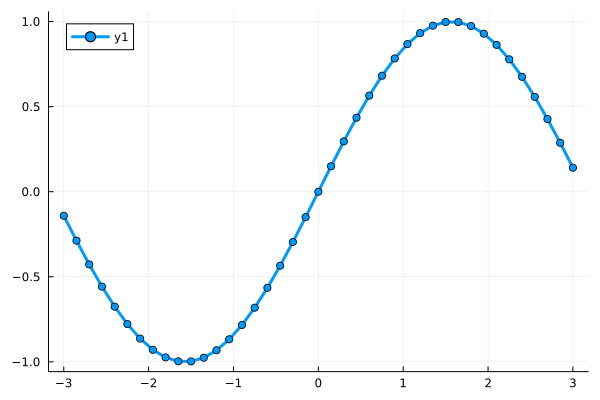

In [1]:
using Plots
default(linewidth=3)

n = 41
h = 6 / (n - 1)
x = LinRange(-3, 3, n)
u = sin.(x) # Note: dot operator allows functions in Julia to accept arrays as arguments and return arrays.
plot(x, u, marker=:circle)

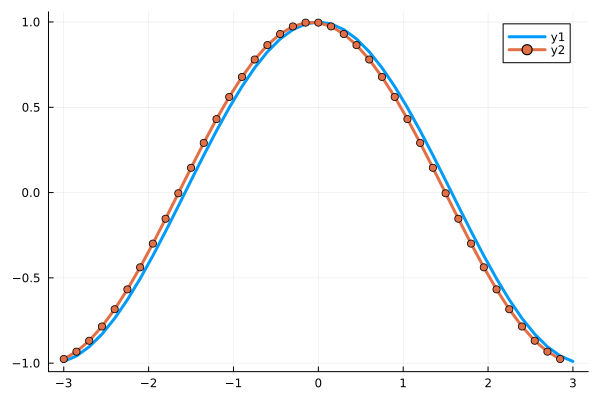

In [2]:
u_x = cos.(x)
fd_u_x = (u[2:end] - u[1:end-1]) / h # What does this do?

plot(x, u_x)
plot!(x[1:end-1], fd_u_x, marker=:circle) # Note: the "!" adds a curve to an existing plot

# How accurate is it?

Without loss of generality, we'll approximate $u'(x_i = 0)$, taking $h = x_{i+1} - x_i$.

$$ u(x) = u(0) + u'(0)x + u''(0)x^2/2! + O(x^3)$$

and substitute into the differencing formula

$$ \begin{split} u'(0) \approx \frac{u(h) - u(0)}{h} = h^{-1} \Big( u(0) + u'(0) h + u''(0)h^2/2 + O(h^3) - u(0) \Big) \\
= u'(0) + u''(0)h/2 + O(h^2) . \end{split}$$

Evidently the error in this approximation is $u''(0)h/2 + O(h^2)$. We say this method is *first order accurate*.

# Homework on stability and accuracy of computing derivatives

* Accept the activity on Canvas
* Clone the repo
  * If you're using coding.csel.io
    * after logging in, select the "CSCI 3656/5636" tile
    * use `gh auth login` from the terminal (you'll only need to do this once)
    * then use the Git sidebar widget to clone
  * `git clone https://github.com/cu-numpde/2025-01-15-derivatives-YOUR-GH-USERNAME` (or with `ssh`)
* Complete the activity, commit your changes, and push.
* A repository called `2025-01-15-intro-to-github` is available to guide you (and so am I and your TA)

# A note on stable computation and floating-point representation 

There are several sources of error in computation:

* roundoff (a consequence of how computers represent numbers)
* conditioning (a property of the problem we're solving)
* stability (a property of the algorithm we're using)

## Roundoff

* If $\circ$ is an operator that rounds a real number $x \in \mathbb{R}$ to the nearest _floating-point number_ $\tilde{x}$:

$$ \tilde{x} := \circ x,$$

* Then the relative error introduced by this representation is

$$ \delta x = \frac{\tilde{x} - x}{x}, $$

* Rearranged:

$$ \tilde{x} = (1 + \delta x)x. $$

* What is a guaranteed _upper bound_ on $\delta x$?

* The IEEE (Institute of Electrical and Electronics Engineers) stadard guarantees that 

$$ |\delta x| < \mu_M = \frac{1}{2}\varepsilon_M $$,

where $\varepsilon_M$ is _machine precision_.

**Question**: What is $\varepsilon_M$ for single- and double-precision arithmetic?

It's around $10^{-7}$ for single-precision, and $10^{-16}$ for double. 
* What does this mean for the number of digits?
* Why would anyone choose single precision?

In [7]:
x = 1e-16
@show 1+x # :-(

1 + x = 1.0


1.0

## Conditioning

With the above in mind, to how many digits can you trust a computer's output of

$$ \sin(\pi/3) $$

and

$$ \sin(10^{10} + \pi/3), $$

if it uses double precision?

This problem (evaluating $\sin$ with a large argument) is _ill-conditioned_. Even the best algorithm cannot be expected to produce a more accurate answer.

## Stability

In [4]:
x = big(1e-15) # Represent this number with maximal precision (much better than double)
@show big(1+x)
@show log(1 + x)

big(1 + x) = 1.000000000000001000000000000000077705399876661079238307185601195015145492561714
log(1 + x) = 9.999999999999995777053998766613348662406422732737965069319591605458493216045864e-16


9.999999999999995777053998766613348662406422732737965069319591605458493216045864e-16

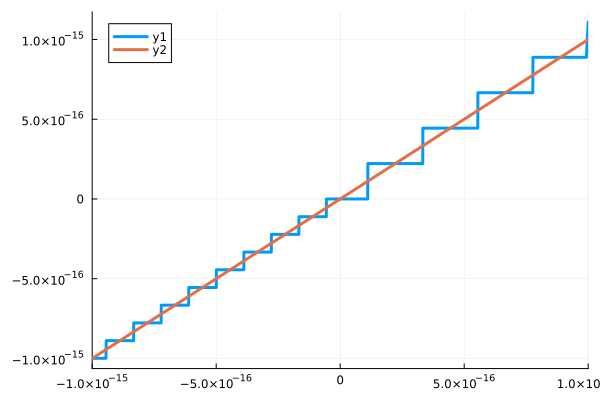

In [5]:
plot([h -> log(1+h), log1p], xlim=(-1e-15, 1e-15)) # What's going on?

A _more stable_ implementation of the $\log(1 + x)$ operation produces a more accurate result.

# A few methods on grids

In [8]:
diff1l(x, u) = x[2:end],   (u[2:end] - u[1:end-1]) ./ (x[2:end] - x[1:end-1])
diff1r(x, u) = x[1:end-1], (u[2:end] - u[1:end-1]) ./ (x[2:end] - x[1:end-1])
diff1c(x, u) = x[2:end-1], (u[3:end] - u[1:end-2]) ./ (x[3:end] - x[1:end-2])
difflist = [diff1l, diff1r, diff1c]

n = 40 
h = 2 / (n - 1)
x = LinRange(-3, 3, n)
u = sin.(x)
fig = plot(cos, xlims=(-3, 3))
for d in difflist
    xx, yy = d(x, u)
    plot!(fig, xx, yy, marker=:circle, label=d)
end

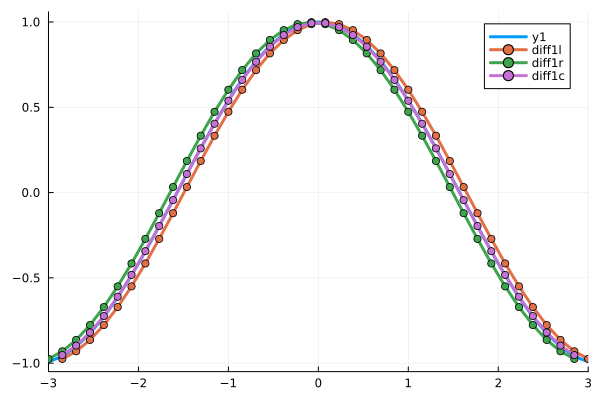

In [9]:
fig

# Measuring errors on grids

In [10]:
using LinearAlgebra
default(legendfontsize=12)

grids = 2 .^ (2:10)
hs = 1 ./ grids
function refinement_error(f, fprime, d)
    error = []
    for n in grids
        x = LinRange(-3, 3, n)
        xx, yy = d(x, f.(x))
        push!(error, norm(yy - fprime.(xx), 2)/sqrt(n))
    end
    error
end

refinement_error (generic function with 1 method)

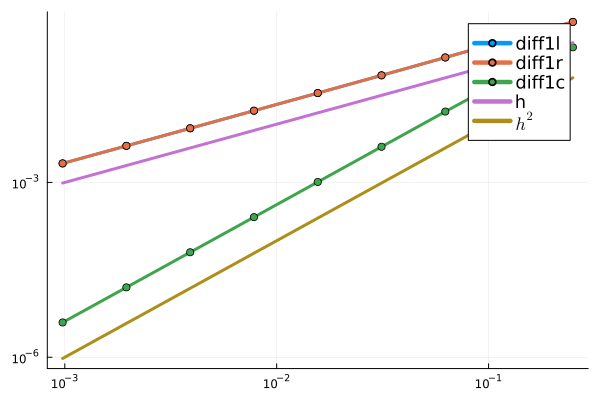

In [11]:
fig = plot(xscale=:log10, yscale=:log10)
for d in difflist
    error = refinement_error(sin, cos, d)
    plot!(fig, hs, error, marker=:circle, label=d)
end
plot!(fig, hs, [hs hs .^ 2], label=["h" "\$h^2\$"])